In [2]:
%matplotlib inline
import scipy.io as sio
import random
import numpy as np
import scipy.misc as smp
import matplotlib.pyplot as plt
import cv2
from sklearn import svm

#For part2, spam classifier
import re
import nltk #For word stemming

In [3]:
a = sio.loadmat('ex6data1.mat')

#Training sets
y = a['y']
X = a['X'] 

yes = np.array([X[i] for i in xrange(len(X)) if y[i] == 1])
no = np.array([X[i] for i in xrange(len(X)) if y[i] == 0])

def plotData():
    plt.plot(yes[:,0],yes[:,1],'k+',label='Positive')
    plt.plot(no[:,0],no[:,1],'yo',label='Negative')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    
#plotData()

In [4]:
def drawDecisionBound(clf,x1min,x1max,x2min,x2max):
   
    x1_v = np.linspace(x1min,x1max,40)
    x2_v = np.linspace(x2min,x2max,40)

    contour_v = np.zeros((len(x1_v),len(x2_v)))
    contour_v = [ [float(clf.predict(np.array([x1_v[i],x2_v[j]]))) \
                 for i in xrange(len(x1_v))] \
                 for j in xrange(len(x2_v)) ]
    
    plt.contour(x1_v, x2_v, contour_v, [0])

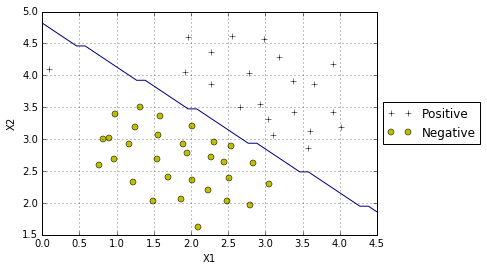

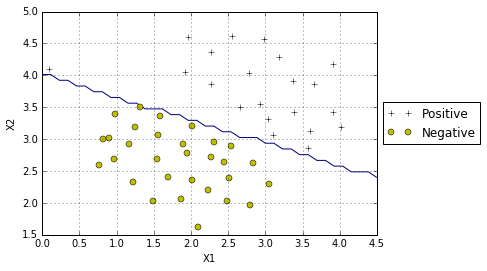

In [5]:
#Hello again scikit!
#http://scikit-learn.org/stable/modules/svm.html
#http://scikit-learn.org/stable/tutorial/basic/tutorial.html
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#Need to pass a row of y's to fit function; X is ok
new_y = y.reshape([1,y.shape[0]])[0]

clf = svm.SVC(gamma=0.01,C=1,kernel='linear')
clf.fit(X,new_y)

plotData()
drawDecisionBound(clf,0,4.5,1.5,5)

clf = svm.SVC(gamma=0.01,C=100,kernel='linear')
clf.fit(X,new_y)

plt.figure()
plotData()
drawDecisionBound(clf,0,4.5,1.5,5)
#Notes to future self: In scikit example, we discounted last parameter
#This parameter in our case is the outlier. Excluding it causes very similar
#decision boundaries

## EXAMPLE DATASET 2

In [6]:
a = sio.loadmat('ex6data2.mat')

#Training sets
y = a['y']
X = a['X'] 

yes = np.array([X[i] for i in xrange(len(X)) if y[i] == 1])
no = np.array([X[i] for i in xrange(len(X)) if y[i] == 0])

In [7]:
import math

def gaussianKernel(x1,x2,sigma):    
    sqSum = float(np.dot((x1 - x2),(x1 - x2).T))
    return math.exp(-1 * sqSum / (2*sigma*sigma))

In [8]:
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, -1])
sigma = 2

print "Gauss Kernel gives value of %.4f" % gaussianKernel(x1,x2,sigma)

Gauss Kernel gives value of 0.3247


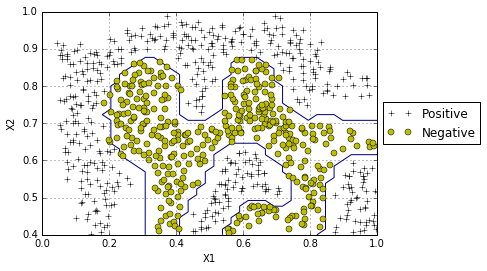

In [9]:
#http://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html
def my_kernel(X,y):
    sigma = 2
    print X[:,0].shape, X[:,1].shape
    sqSum = float( np.dot((X[:,0] - X[:,1]),(X[:,0] - X[:,1]).T) )
    return math.exp(-1 * sqSum / 2*sigma*sigma)

#clf = svm.SVC(gamma=0.01,C=1,kernel=my_kernel)
#clf.fit(X,y)
#Can't seem to make this work-- come back to this
#For now, use built in kernel

new_y = y.reshape([1,y.shape[0]])[0]
clf = svm.SVC(gamma=200,C=1,kernel='rbf')
clf.fit(X,new_y)
plt.figure()
plotData()
drawDecisionBound(clf,0,1,0.4,1)

## EXAMPLE DATASET 3

In [10]:
a = sio.loadmat('ex6data3.mat')

#Training sets
y = a['y']
X = a['X']

yval = a['yval']
Xval = a['Xval']

yes = np.array([X[i] for i in xrange(len(X)) if y[i] == 1])
no = np.array([X[i] for i in xrange(len(X)) if y[i] == 0])

C and sigma are  3 30


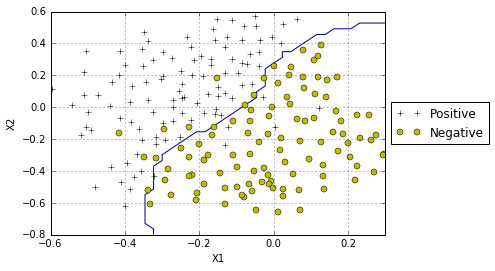

In [11]:
#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
C = [ 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30 ]
sigma = [ 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30 ]

new_y = y.reshape([1,y.shape[0]])[0]
new_yval = yval.reshape([1,yval.shape[0]])[0]

max_score = -1
C_at_max_score = -1  
s_at_max_score = -1
max_clf = 0

for c in C:
    for s in sigma:
        clf = svm.SVC(gamma=s,C=c,kernel='rbf')
        clf.fit(X,new_y)
        score = clf.score(Xval,new_yval)
        if score > max_score:
            max_score = score
            C_at_max_score = c
            s_at_max_score = s
            max_clf = clf

            
print "C and sigma are ", C_at_max_score, s_at_max_score
new_y = y.reshape([1,y.shape[0]])[0]
plt.figure()
plotData()
drawDecisionBound(max_clf,-0.6,0.3,-0.8,0.6)

## SPAM CLASSIFIER HOW COOL IS THIS

In [12]:
#First need to replace a bunch of strings using regex, 
#since not using OCTAVE. 

def normalize(email):

    email = email.lower() 
    
    email = re.sub('<[^<>]+>',' ',email)
    email = re.sub('[0-9]+','number',email)
    email = re.sub('(http|https)://[^\s]*','httpaddr',email)
    email = re.sub('[^\s]+@[^\s]+','emailaddr',email);
    email = re.sub('[$]+', 'dollar',email);
    
    return email

In [13]:
from nltk.stem.porter import *

def wordStems(email):
    
    norm_email = normalize(email)
    
    stemmer = PorterStemmer()
    word_stem_v = re.sub('[^a-zA-Z0-9]',' ',norm_email)
    word_stem_v = word_stem_v.split(' ')
    
    singles = [str(stemmer.stem(word)) for word in word_stem_v if len(word)!= 0]
    
    new_email = str()
    
    for i in singles:
        new_email+= i + ' '
    
    return new_email

In [14]:
def processEmail(email,vocab):
    
    email = wordStems(email)
    em = email.split(' ')    
    word_indices = []
    words = []
    
    # Here we will map vocab to indices in vocab list
    for word in em:
        if word in vocab[1]:
            it = np.where(vocab == word)
            word_indices.append( int(it[1] + 1) )
            words.append(word)   

    #print words
    return word_indices

In [15]:
def emailFeatures(email,vocab):
    
    word_indices = processEmail(email,vocab)
    feature_v = np.zeros([len(vocab[0]),1])
    ones = 0
    
    for w in word_indices:
        
        if feature_v[w] == 0:
            ones += 1
    
            feature_v[w] = 1
        
    #print "Feature vec has len %d with %i spam words" % (len(feature_v),ones)    
    return feature_v

In [16]:
email = open( 'emailSample1.txt', 'r' ).read()
vocab = open( 'vocab.txt', 'r' ).read()
vocab = np.loadtxt('vocab.txt',dtype=np.str,unpack=True)

print vocab[1]

_ = emailFeatures(email,vocab)

['aa' 'ab' 'abil' ..., 'zdnet' 'zero' 'zip']


In [17]:
train_m = sio.loadmat('spamTrain.mat')
test_m = sio.loadmat('spamTest.mat')

X = np.array(train_m['X']) 
y = np.array(train_m['y'])

Xtest = np.array(test_m['Xtest']) 
ytest = np.array(test_m['ytest'])

y_new     = y.reshape([1,y.shape[0]])[0]
ytest_new = ytest.reshape([1,ytest.shape[0]])[0]

In [18]:
clf = svm.SVC(C=1,kernel='linear')
clf.fit(X,y_new)

ypred = clf.predict(X)
ytest_pred = clf.predict(Xtest)

In [19]:
y_r = y.reshape(-1)
ytest_r = ytest.reshape(-1)

# Find all cases where XNOR conditions satisfied
# That is, when email is spam (not spam), it is classified 1 (0)
# Same as NOT(aXORb)
tr_acc   = float( sum( 1 - (y_r ^ ypred) ) ) / y_r.shape[0] * 100.
test_acc = float( sum( 1 - (ytest_r ^ ytest_pred) ) ) / ytest_r.shape[0] * 100.

# CLOSE ENOUGH; my C value is unoptimized
print "Training accuracy is %.2f, test accuracy %.2f " %(tr_acc,test_acc)

Training accuracy is 99.98, test accuracy 97.80 


In [20]:
indices = clf.coef_

#argsort sorts from lowest->hights. To get highest weights, reverse
s_indices = np.argsort(clf.coef_,axis=None)[::-1] #[0][-1:]

spam_words, nonspam_words = [], []
for i in xrange(0,15):
    spam_words.append(vocab[1][s_indices[i]])
    
for i in xrange(-1,-16,-1):
    nonspam_words.append(vocab[1][s_indices[i]])

print "Top 15 spam words: ", spam_words
print "\nBottom 15 spam words: ", nonspam_words

Top 15 spam words:  ['our', 'flash', 'wi', 'numberb', 'remov', 'visit', 'click', 'bodi', 'guarante', 'send', 'tel', 'instruct', 'dollarnumb', 'tm', 'basenumb']

Bottom 15 spam words:  ['stuff', 'wrote', 'rpm', 'kill', 'address', 'still', 'spamassassin', 'date', 'instead', 'url', 'etc', 'httpaddr', 'the', 'user', 'such']


In [21]:
email1 = open( 'emailSample1.txt', 'r' ).read()
email2 = open( 'emailSample2.txt', 'r' ).read()

spam1 = open( 'spamSample1.txt', 'r' ).read()
spam2 = open( 'spamSample2.txt', 'r' ).read()

e1_features = emailFeatures(email1,vocab)
e2_features = emailFeatures(email2,vocab)
s1_features = emailFeatures(spam1,vocab)
s2_features = emailFeatures(spam2,vocab)

e1_y = clf.predict(e1_features.T)
e2_y = clf.predict(e2_features.T)
s1_y = clf.predict(s1_features.T)
s2_y = clf.predict(s2_features.T)
print e1_y , e2_y, s1_y, s2_y

[1] [0] [1] [1]


In [22]:
# Test out on my own emails!! 
ahack_mail = open( 'ahack_test5.txt', 'r' ).read()
ahack_features = emailFeatures(ahack_mail,vocab)

ahack_result = clf.predict(ahack_features.T)
print ahack_result

# Notes for future ariana:
#
# Either I messed something up, or the svm thinks most physics emails are spam;
# though, mom emails seem safe from the wrath of the svm, which I guess mom will like.
# Most of my email is with working groups; often involves many numbers/cost discussions, 
# paper links, unusual english words ("pion", "kaon", etc.); possibly related.

[1]
